# Clasificación para inversión usando CNN

Se cargan las imagenes generadas con su cluster correspondiente (_cluster.ipynb_) y son entrenados usando una CNN con 80% de datos de entrenamiento y 20% de prueba.

## Librerias

Pandas es usado para realizar operaciones sobre el dataframe, tensorflow se utiliza para cargar el modelo CNN, matplotlib para graficar y sklearn para crear el conjunto de entrenamiento y prueba.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from os import listdir
from matplotlib import image

from sklearn.model_selection import train_test_split

## Validación del modelo

### Carga de las imagenes
Carga de imagenes del directorio y creacióin de dataframe para modelado.

In [2]:
moneda = 'BTC-USD'
#Ventana de tiempo: 1 para diario, 7 para semanal, 30 para mensual
window_MA = 1

#Carga de imagenes generadas
loaded_images = pd.DataFrame(columns = ['IMG','Cluster'])
img = []
label = []
for filename in listdir('/Users/sacbe/Documents/Tesis licenciatura/Algoritmos/IMG/'+ str(moneda) +'_'+ str(window_MA)):
    if filename == '.DS_Store':
        continue
    img_data = image.imread('/Users/sacbe/Documents/Tesis licenciatura/Algoritmos/IMG/'+str(moneda)+'_'+str(window_MA)+'/'+filename)
    img.append(img_data)
    label.append(filename[-5])

    
loaded_images['IMG'] = img
loaded_images['Cluster'] = label

### Creación de conjunto de entrenamiento y prueba
Se reestructuran las imagenes para el modelo de entrenamiento y se dividen los datos totales en un 20% para pruebas y 80% como conjunto de entrenamiento para evitar sobreajuste.

In [3]:
train, test = train_test_split(loaded_images, test_size=0.2)

train_img0 = np.asarray(train['IMG'])
test_img0 = np.asarray(test['IMG'])

train_img = np.arange(1024).reshape((32, 32))
test_img = np.arange(1024).reshape((32, 32))

for array in train_img0:
    train_img = np.concatenate([train_img, array])

for array in test_img0:
    test_img = np.concatenate([test_img, array])

train_img = np.delete(train_img, np.arange(32), axis=0)
test_img = np.delete(test_img, np.arange(32), axis=0)

train_img = train_img.reshape(-1,32,32,1)
test_img = test_img.reshape(-1,32,32,1)

### Agrupamiento en vender, comprar o incertidumbre

El agrupamiento correspondiente de las imagenes del conjunto de prueba son renombrados a terminos financieros para tener una clasificación clara.

In [4]:
s = pd.Series(np.arange(len(train)))
train = train.set_index(s)
j = 0

for i in train['Cluster']:
    if(i == '2' or i == '4' or i == '6' or i == '8'):
        train['Cluster'][j] = 2 #Vende
    elif(i == '3' or i == '9'):
        train['Cluster'][j] = 1 #Incertidumbre
    else:
        train['Cluster'][j] = 0 #Compra
    j = j + 1
        

s = pd.Series(np.arange(len(test)))
test = test.set_index(s)

j = 0
for i in test['Cluster']:
    if(i == '2' or i == '4' or i == '6' or i == '8' ):
        test['Cluster'][j] = 2 #Vende
    elif(i == '3'or i == '9'):
        test['Cluster'][j] = 1 #Incertidumbre
    else:
        test['Cluster'][j] = 0 #Compra
    j += 1


In [5]:
train_cluster = np.asarray(train['Cluster']).astype('uint8').reshape(-1,1)
test_cluster = np.asarray(test['Cluster']).astype('uint8').reshape(-1,1)

### Presentación de imagenes generadas

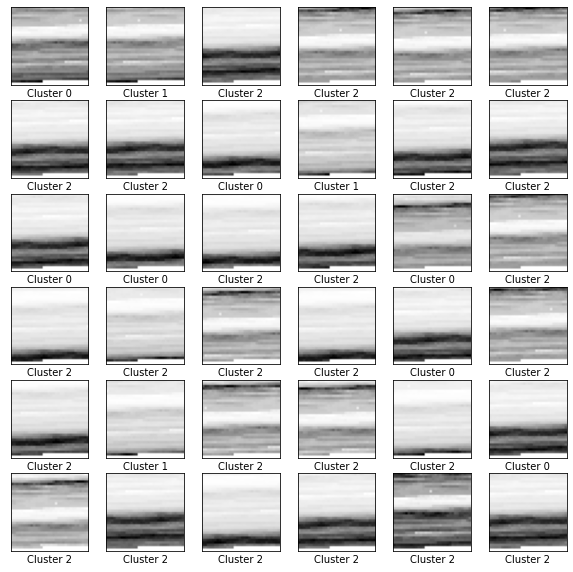

In [6]:
#class_names = ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7','Cluster 8','Cluster 9']
class_names = ['Cluster 0', 'Cluster 1', 'Cluster 2']

plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_img[i].reshape(32,32), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_cluster[i][0]])
plt.show()

### Creación y configuración del modelo

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-03 10:15:32.009266: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-03 10:15:32.009644: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
model.add(layers.Flatten())
model.add(layers.Dense(2560, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 256)        0

### Entrenamiento


In [9]:
%%time
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_img, train_cluster, epochs=50,
                    validation_data=(test_img, test_cluster))

Epoch 1/50


2022-05-03 10:15:38.755000: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/33 [..............................] - ETA: 12s - loss: 1.0952 - accuracy: 0.5625

2022-05-03 10:15:38.975149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 1s 23ms/step - loss: 0.6673 - accuracy: 0.7067 - val_loss: 0.3924 - val_accuracy: 0.7846
Epoch 2/50
 5/33 [===>..........................] - ETA: 0s - loss: 0.3154 - accuracy: 0.8250

2022-05-03 10:15:39.806662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 0s 14ms/step - loss: 0.2947 - accuracy: 0.8894 - val_loss: 0.2620 - val_accuracy: 0.9192
Epoch 3/50
33/33 [==============================] - 1s 17ms/step - loss: 0.2332 - accuracy: 0.9173 - val_loss: 0.2078 - val_accuracy: 0.9269
Epoch 4/50
33/33 [==============================] - 0s 15ms/step - loss: 0.1949 - accuracy: 0.9337 - val_loss: 0.1930 - val_accuracy: 0.9269
Epoch 5/50
33/33 [==============================] - 0s 15ms/step - loss: 0.1597 - accuracy: 0.9394 - val_loss: 0.2444 - val_accuracy: 0.9000
Epoch 6/50
33/33 [==============================] - 0s 14ms/step - loss: 0.1683 - accuracy: 0.9385 - val_loss: 0.2529 - val_accuracy: 0.8923
Epoch 7/50
33/33 [==============================] - 0s 15ms/step - loss: 0.1581 - accuracy: 0.9442 - val_loss: 0.2020 - val_accuracy: 0.9000
Epoch 8/50
33/33 [==============================] - 0s 15ms/step - loss: 0.1589 - accuracy: 0.9442 - val_loss: 0.2777 - val_accuracy: 0.9077
Epoch 9/50
33/33 [======

### Resultados del entrenamiento

9/9 - 0s - loss: 0.1046 - accuracy: 0.9577 - 82ms/epoch - 9ms/step
0.9576923251152039


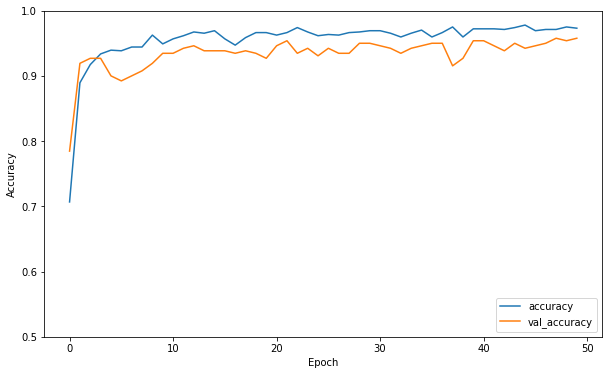

In [10]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_img,  test_cluster, verbose=2)
print(test_acc)
#model.save('CNN_'+str(moneda)+'_'+str(window_MA)+'_Sum.h5')

## Guardado del modelo

In [11]:
moneda = 'BTC-USD'
#Ventana de tiempo: 1 para diario, 7 para semanal, 30 para mensual
window_MA = 1

#Carga de imagenes generadas
loaded_images = pd.DataFrame(columns = ['IMG','Cluster'])
img = []
label = []
for filename in listdir('/Users/sacbe/Documents/Tesis licenciatura/Algoritmos/IMG/'+ str(moneda) +'_'+ str(window_MA)):
    if filename == '.DS_Store':
        continue
    img_data = image.imread('/Users/sacbe/Documents/Tesis licenciatura/Algoritmos/IMG/'+str(moneda)+'_'+str(window_MA)+'/'+filename)
    img.append(img_data)
    label.append(filename[-5])

    
loaded_images['IMG'] = img
loaded_images['Cluster'] = label

train = loaded_images

train_img0 = np.asarray(train['IMG'])
train_img = np.arange(1024).reshape((32, 32))

for array in train_img0:
    train_img = np.concatenate([train_img, array])

train_img = np.delete(train_img, np.arange(32), axis=0)
train_img = train_img.reshape(-1,32,32,1)

s = pd.Series(np.arange(len(train)))
train = train.set_index(s)
j = 0

for i in train['Cluster']:
    if(i == '2' or i == '4' or i == '6' or i == '8'):
        train['Cluster'][j] = 2 #Vende
    elif(i == '3' or i == '9'):
        train['Cluster'][j] = 1 #Incertidumbre
    else:
        train['Cluster'][j] = 0 #Compra
    j = j + 1
        

train_cluster = np.asarray(train['Cluster']).astype('uint8').reshape(-1,1)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_img, train_cluster, epochs=50)
print("Modelo guardado.")
model.save('CNN_'+str(moneda)+'_'+str(window_MA)+'_Sum.h5')

Epoch 1/50
 5/41 [==>...........................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9938 

2022-05-03 10:16:32.788450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 1s 14ms/step - loss: 0.0932 - accuracy: 0.9700
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0828 - accuracy: 0.9669
Epoch 3/50
41/41 [==============================] - 1s 12ms/step - loss: 0.0827 - accuracy: 0.9669
Epoch 4/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0641 - accuracy: 0.9754
Epoch 5/50
41/41 [==============================] - 1s 12ms/step - loss: 0.0829 - accuracy: 0.9685
Epoch 6/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0803 - accuracy: 0.9685
Epoch 7/50
41/41 [==============================] - 1s 12ms/step - loss: 0.0880 - accuracy: 0.9685
Epoch 8/50
41/41 [==============================] - 1s 12ms/step - loss: 0.0684 - accuracy: 0.9662
Epoch 9/50
41/41 [==============================] - 1s 12ms/step - loss: 0.0595 - accuracy: 0.9762
Epoch 10/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0630 - accuracy: 0.9762
Epoch 11/50
41/41 [=